In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams['figure.figsize'] = (10, 6)

In [35]:
df=pd.read_csv(r'MLTempDataset.csv',parse_dates=True,index_col='Datetime')
df.drop(columns=['Unnamed: 0','Datetime1'],axis=1,inplace=True)
df.head()

,DAYTON_MW
Datetime,
2022-01-04 00:00:00,20.87
2022-01-04 01:00:00,21.00
2022-01-04 02:00:00,20.87
2022-01-04 03:00:00,20.65
2022-01-04 04:00:00,20.40


Text(0.5, 1.0, 'Room temperature')

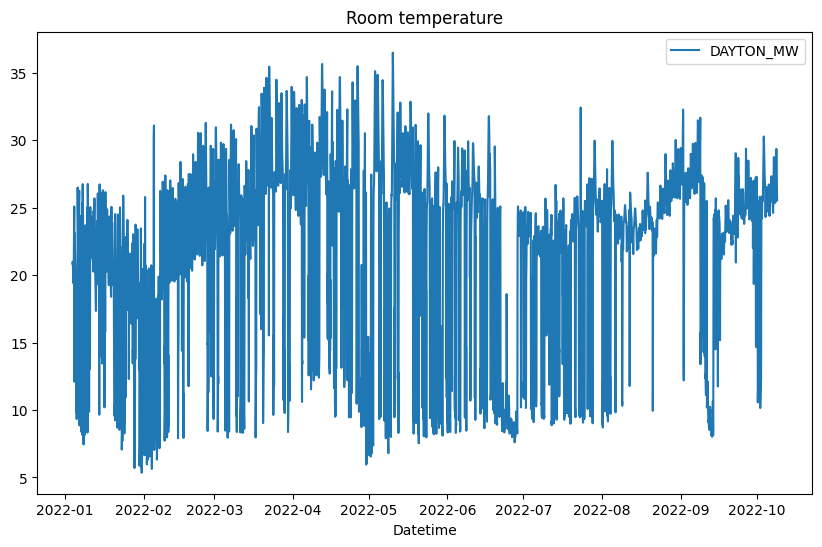

In [36]:
# initial data
sns.lineplot(df)
plt.title('Room temperature')

In [37]:
# Aggregate data by day to improve prediction
dff = df.resample(rule='D').mean()

Text(0.5, 1.0, 'Aggregation of temperature by day')

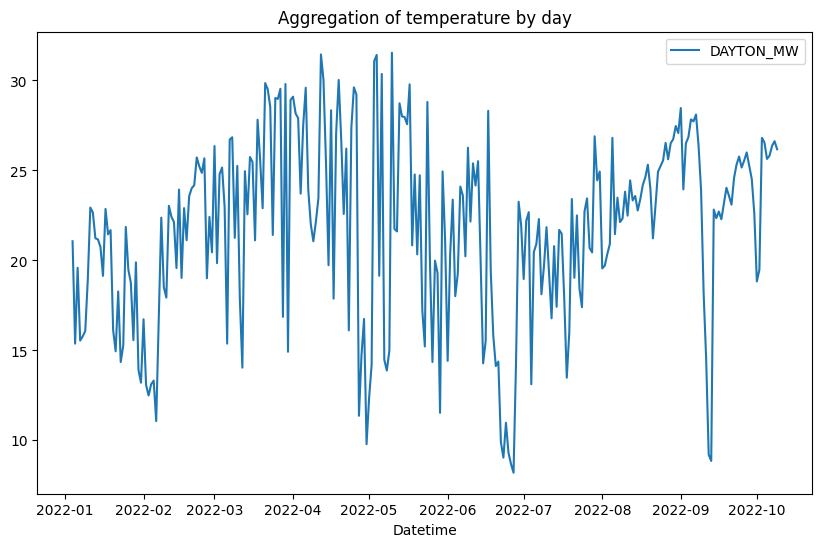

In [38]:
sns.lineplot(dff)
plt.title('Aggregation of temperature by day')

# Series analysis

In [39]:
df.describe()

,DAYTON_MW
count,6676.00
mean,21.74
std,6.85
min,5.35
25%,17.51
50%,23.90
75%,26.37
max,36.50


* The minimum temperature for the year of the year was January 31 at 7 o'clock and was equal to 5 degrees
* The maximum temperature for the year of the year was on May 10 at 10 o'clock and was equal to 36.5 degrees
* The average temperature in the room is 21 degrees
* On average, the highest temperature was 24.7 degrees in September, and the lowest was 18.15 degrees on average in June

## Checking the time series for stationarity

In [40]:
#Let 's check the series for stationarity with the Dickey - Fuller test
print('p-value = ' + str(adfuller(df)[1]))

p-value = 2.694362701457337e-15


* p-value = 2.694362701457337e-15 < 0.05 
* The row is stationary

## Check for white noise and random walk

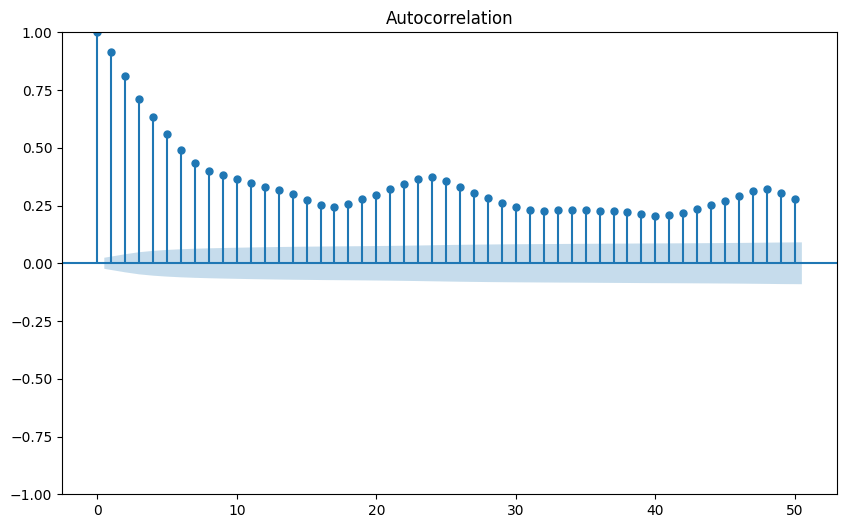

In [41]:
# Whether the series is stationary can be checked using a correlogram
plot_acf(df,lags=50)
plt.show()

* The row is not white noise, as there are lags that are greater than zero
* The series is not a random walk, since the Dickey-Fuller test indicates the stationarity of the series, and also the series does not have a strong linear dependence and does not decay linearly.

## Decomposition of a time series

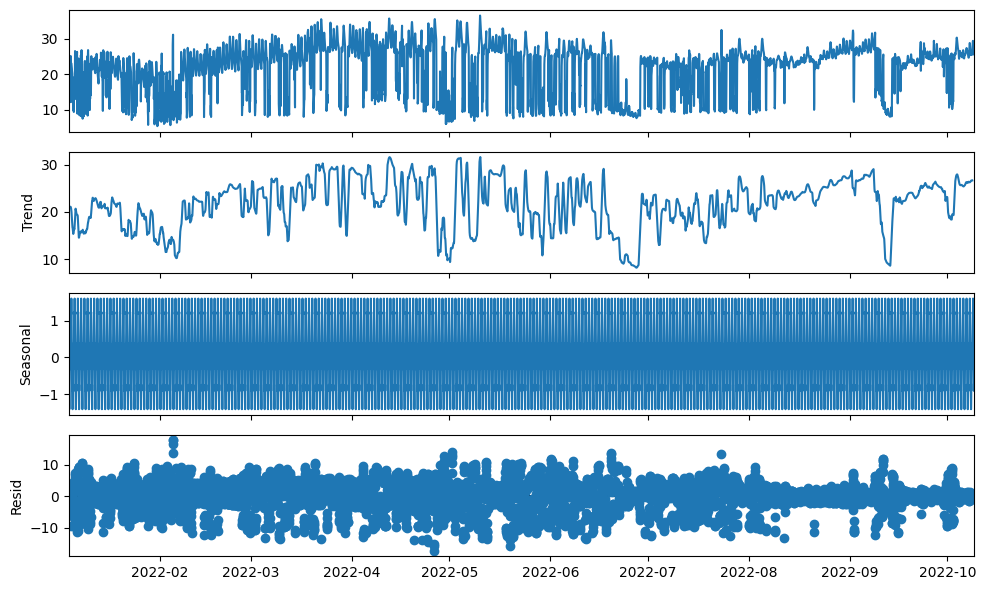

In [42]:
seasonal_decompose(df).plot()
plt.show()

* Since the time series is stationary , it means that it has no trend and seasonality

## Moving Average

<Axes: xlabel='Datetime'>

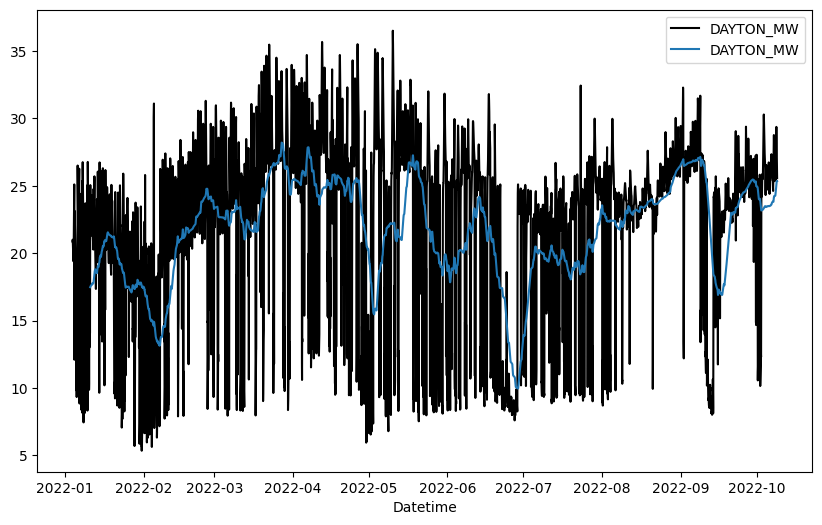

In [88]:
# Weekly moving average
sns.lineplot(data=df, palette=["black"])
sns.lineplot(df.rolling(window=24*7).mean().dropna())

* The highest temperature in the room is observed in winter, spring and autumn. This is most likely due to the work of heating in the house. And the lowest temperatures are observed in the summer, since the heating does not work

# Creating new variables

In [44]:
df=pd.read_csv(r'MLTempDataset.csv',parse_dates=True,index_col='Datetime')
df.drop(columns=['Unnamed: 0','Datetime1'],axis=1,inplace=True)
# We make data for training and test
df['Moving_Average'] = df.rolling(window=24).mean() # daily moving average
df['%'] = df.DAYTON_MW.pct_change().mul(100) # displays how much the new values have changed relative to the old one as a percentage
df['lag_1'] = df.DAYTON_MW.shift(periods=1) # lag 1
df['lag_2'] = df.DAYTON_MW.shift(periods=2) # lag 2
df.dropna(inplace=True)

In [45]:
train  = df[:'2022-07']
test = df['2022-08':]
X_tarin = train.drop('DAYTON_MW',axis=1)
X_test = test.drop('DAYTON_MW',axis=1)
y_tarin = train['DAYTON_MW']
y_test = test['DAYTON_MW']

<Axes: xlabel='Datetime', ylabel='DAYTON_MW'>

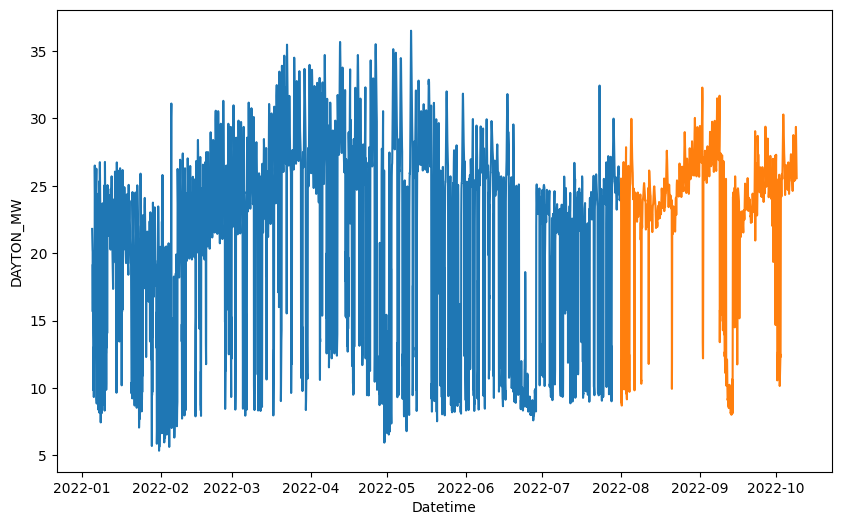

In [46]:
sns.lineplot(y_tarin)
sns.lineplot(y_test)

# Models

## Linear regression

In [47]:
import statsmodels.api as sm
X_1=sm.add_constant(X_tarin)
lr=sm.OLS(endog=y_tarin,exog=X_1)
result=lr.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              DAYTON_MW   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 4.220e+04
Date:                Thu, 01 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:53:56   Log-Likelihood:                -8174.0
No. Observations:                4993   AIC:                         1.636e+04
Df Residuals:                    4988   BIC:                         1.639e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5226      0.075     -6.

In [48]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_tarin,y_tarin)
print('linear regression',lr.score(X_test,y_test)) 

linear regression 0.9738948635642709


In [49]:
pred=lr.predict(X_test)
predd=pd.Series(pred,index=y_test.index) 

In [89]:
from sklearn.metrics import mean_absolute_error, r2_score
print('MSE:',mean_absolute_error(y_test, predd))
print("r2:",r2_score(y_test, predd))

MSE: 0.37071851086936974
r2: 0.9738948635642709


* The model is wrong by 0.37 degrees

Text(0.5, 1.0, 'Model predictions based on linear regression')

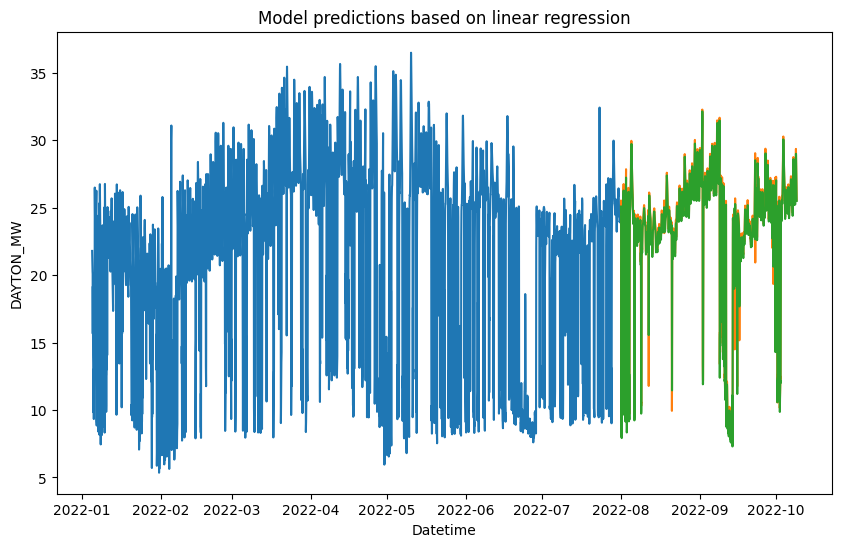

In [51]:
sns.lineplot(y_tarin)
sns.lineplot(y_test)
sns.lineplot(predd)
plt.title('Model predictions based on linear regression')

#  Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
model=RandomForestRegressor()
model.fit(X_tarin,y_tarin)
r_pred=model.predict(X_test)
r_predd=pd.Series(r_pred,index=y_test.index)

Text(0.5, 1.0, 'Model predictions on the forest')

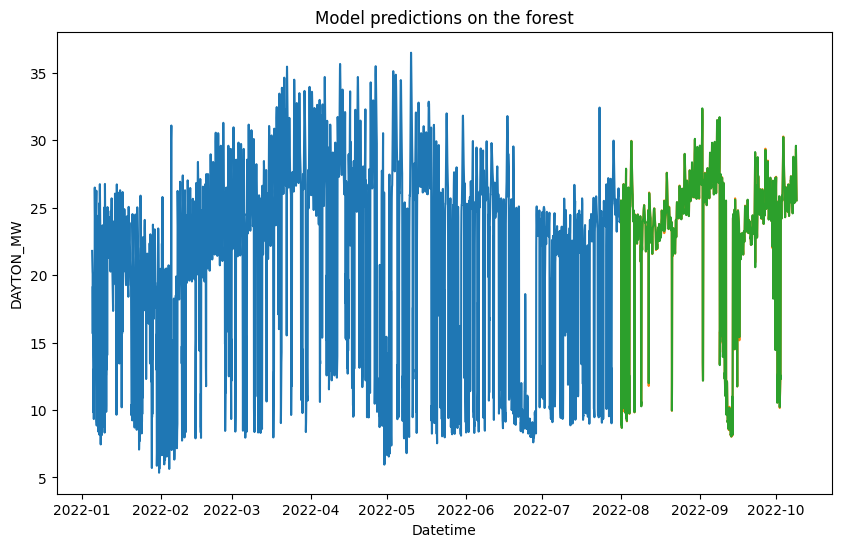

In [54]:
sns.lineplot(y_tarin)
sns.lineplot(y_test)
sns.lineplot(r_predd)
plt.title('Model predictions on the forest')

In [55]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, r_predd))
 
print('MSE:',mse(y_test, r_predd))

0.01153528635789156
MSE: 0.04535258433734955


* The model is wrong by 0.04 degrees

In [56]:
df = pd.read_csv('MLTempDataset.csv')

# Prepare the dataframe for Prophet
df_prophet = pd.DataFrame()
df_prophet['ds'] = pd.to_datetime(df['Datetime'])
df_prophet['y'] = df['DAYTON_MW']

In [57]:
from sklearn.model_selection import train_test_split
from prophet import Prophet

# Initialize the Prophet model
m = Prophet(daily_seasonality=True,weekly_seasonality=True,seasonality_mode="additive")
# Split the data into training and testing sets
train, test = train_test_split(df_prophet, test_size=0.2, shuffle=False)


# Fit the model with your dataframe
# Initialize and fit the Prophet model with training data
m = Prophet()
m.fit(train)


09:53:59 - cmdstanpy - INFO - Chain [1] start processing
09:53:59 - cmdstanpy - INFO - Chain [1] done processing


In [58]:

# Create a future dataframe for the testing period
future_test = m.make_future_dataframe(periods=len(test), include_history=False)
forecast_test = m.predict(future_test)

c:\Users\71528\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\71528\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


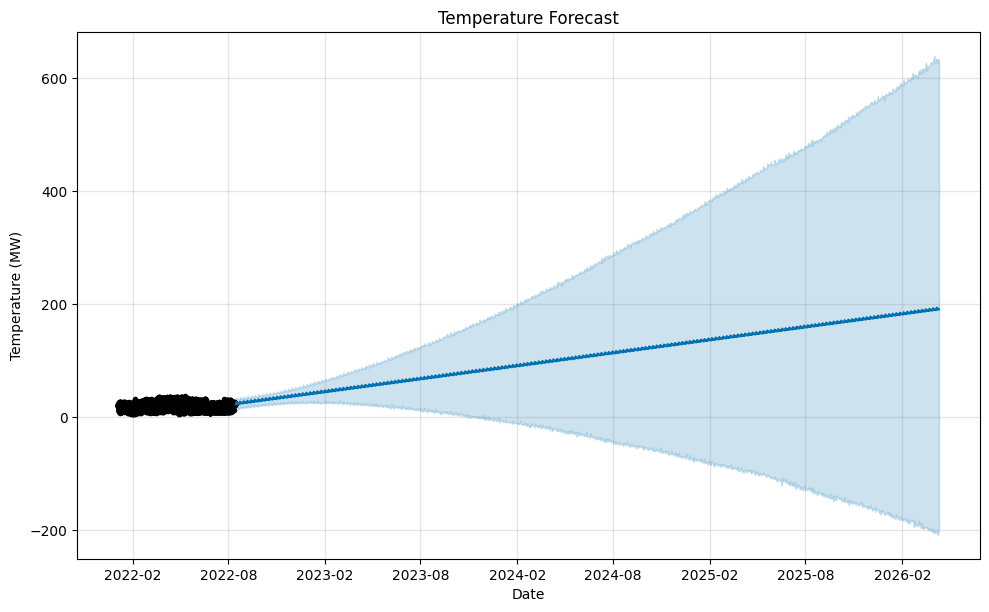

In [59]:
fig1 = m.plot(forecast_test)
plt.title("Temperature Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (MW)")
plt.show()


C:\Users\71528\AppData\Local\Temp\ipykernel_1204\2628356893.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample(rule='H').mean().reset_index()
11:46:05 - cmdstanpy - INFO - Chain [1] start processing
11:46:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\71528\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


                      ds  yhat  yhat_lower  yhat_upper
6671 2022-10-08 23:00:00 30.56       21.15       39.24
6672 2022-10-09 00:00:00 29.76       21.49       39.22
6673 2022-10-09 01:00:00 29.08       19.75       37.57
6674 2022-10-09 02:00:00 28.64       19.91       37.17
6675 2022-10-09 03:00:00 28.35       19.28       36.89


c:\Users\71528\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\71528\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\71528\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

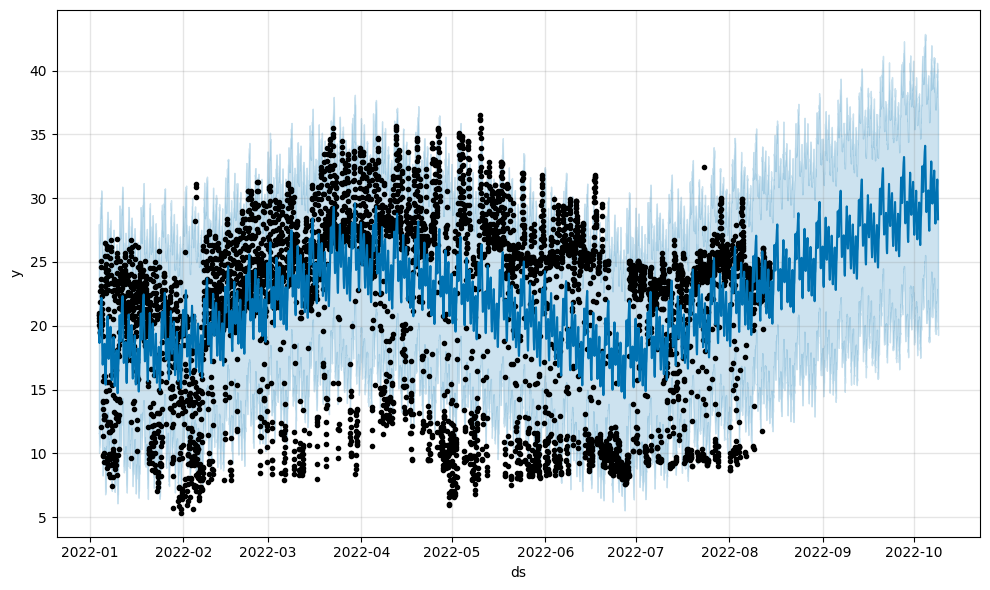

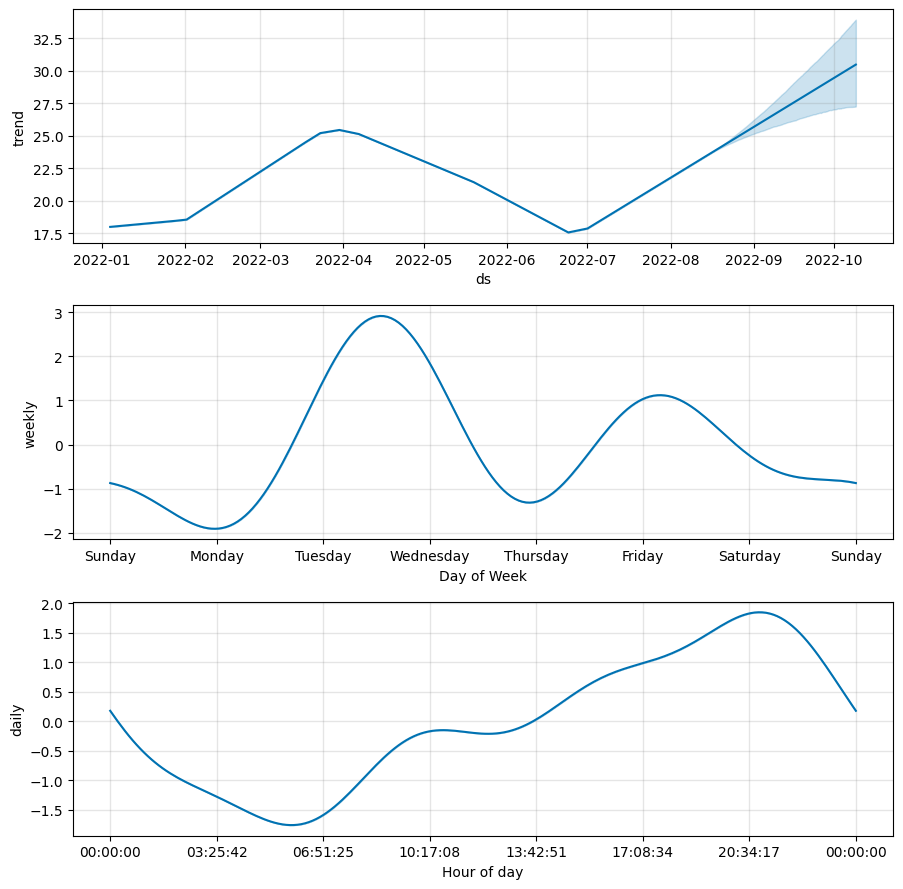

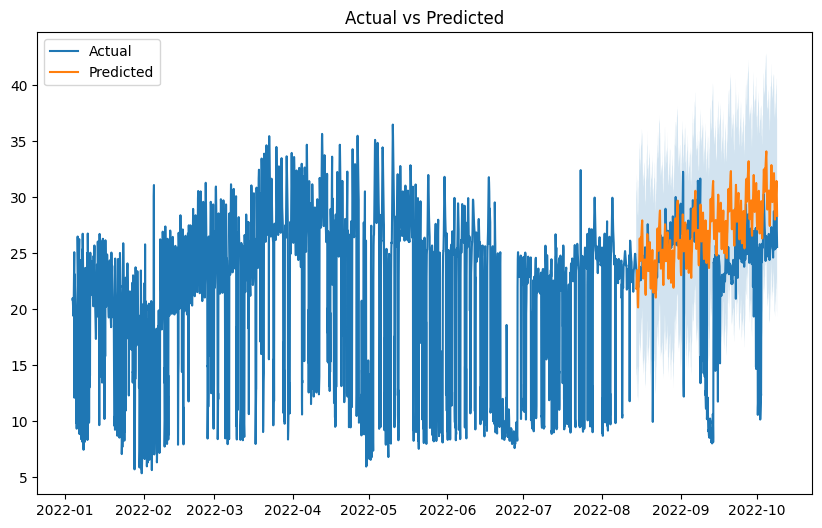

MAE: 4.11892348494876
MSE: 37.17708507664045


In [78]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet

# Load the dataset
df = pd.read_csv('MLTempDataset.csv', parse_dates=True, index_col='Datetime')
df.drop(columns=['Unnamed: 0', 'Datetime1'], axis=1, inplace=True)

# Resample to hourly data
df_hourly = df.resample(rule='H').mean().reset_index()

# Prepare data for Prophet
df_prophet = df_hourly.copy()
df_prophet.columns = ['ds', 'y']  # Rename columns for Prophet

# Split the data into training and testing sets
size = int(len(df_prophet) * 0.8)
train = df_prophet.iloc[:size]
test = df_prophet.iloc[size:]

# Initialize the Prophet model with daily and weekly seasonality
m = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode="additive")

# Fit the model with the training set
m.fit(train)

# Create a future dataframe for forecasting, including the test period
future = m.make_future_dataframe(periods=len(test), freq='H')

# Make predictions
forecast = m.predict(future)

# Review forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
fig1 = m.plot(forecast)

# Plot the components
fig2 = m.plot_components(forecast)

# Evaluate the model
# Extract the forecasted values for the test period
forecast_test = forecast.iloc[-len(test):]

# Combine the test set with forecasted values
results = test.copy()
results['yhat'] = forecast_test['yhat'].values
results['yhat_lower'] = forecast_test['yhat_lower'].values
results['yhat_upper'] = forecast_test['yhat_upper'].values

# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(results['ds'], results['yhat'], label='Predicted')
plt.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], alpha=0.2)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(results['y'], results['yhat'])
mse = mean_squared_error(results['y'], results['yhat'])
print(f'MAE: {mae}')
print(f'MSE: {mse}')
